# The Task

1) Train, tune and cross-validate models on PSG labels.
2) Pick the "best" model and predict sleep/wake status of unseen AX3 data.
3) Compare this "best" model's predictions to AWS labels and calculate performance metrics (both epoch-by-epoch and sleep quality metrics)

The aim is for our performance to surpass that of the "Biobank" model, based on these metrics.

## Problem: Label Mismatch

The PSG and AWS labels for the 35 individuals in our dataset disagree for a considerable percentage (up to 32%) of epochs recorded in the lab. This misalignment between training (PSG) and test (AWS) targets has implications for the performance of any model trained on this particular PSG dataset, when measured against AWS labels.

Let's focus on the meaning of "best" in step 2 above. During the model development phase, we only have access to PSG labels. Our criteria for evaluating our candidate models is how closely their outputs match PSG (e.g. when cross-validating). Model A will be considered better than model B, if its output matches PSG labels more closely.

Following this argument, the "best" model that can possibly be trained given PSG labels, is the one that matches PSG for every single epoch. All performance metrics for such a hypothetical model would be 100%.

Let's call this hypothetical perfect model the Perfect-PSG-35. This is the very best model that anyone can come up with, given our dataset of 35 PSG-labelled subjects.

I show below that the F-1 score for this model is 0.81. This is, by construction, the best model that we can possibly hope to build.

### A Simulation Study
Before diving into the details, let me first show you a simulation study. I simulate the output of (hypothetical) models by taking the PSG labels (the targets) and injecting varying amounts of random noise into them. We can pretend that this new vector of 1s and 0s is the output of a fictional model that predicts PSG correctly in certain places but makes mistake for other epochs.

We can then evaluate our hypothetical model for the same epochs on both PSG and AWS. The former will measure how then model would have performed during model development phase (when cross validating on PSG) while the latter measures its test-set performance.

I repeat this prcoess 200 times and plot the relationship between the two performance metrics. Not surprisingly, this shows that none of the simulated model can exceed F1=0.81.

The code for this simulation is at the end of this notebook.

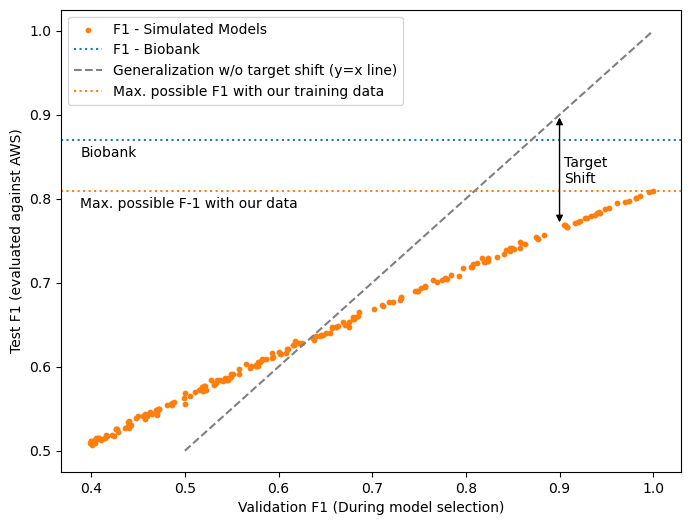
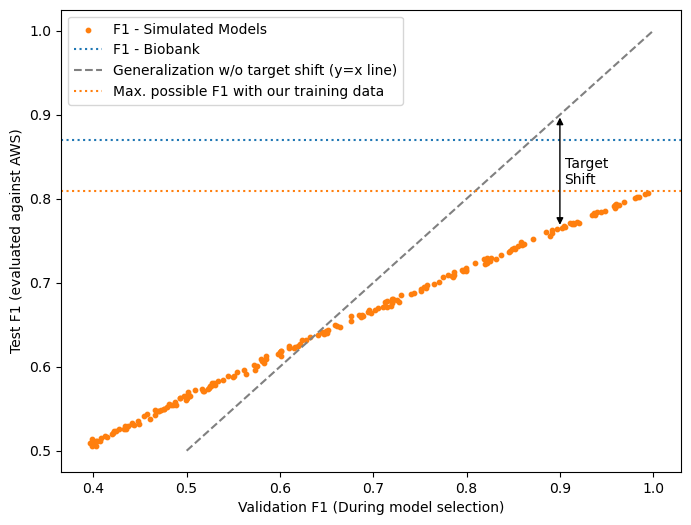

## The Details
Let's now get back to our Perfect-PSG-35 model, and evalute its performance on AWS labels (Step 3 above). Remember that the output of our model is always equal to PSG labels.

Both PSG and AWS labels are avaialble for the first 18 subjects during lab-day.
Let's first load the PSG and AWS labels.

In [1]:
from data_utils import read_PSG_labels, read_AWS_labels
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
aws_labels_path = 'data/AWS-Labels'
psg_labels_path = 'data/PSG-Labels'

psg_df = pd.DataFrame()
for id in range(1, 18+1):

    subject_psg_df = read_PSG_labels(psg_labels_path, id)
    subject_psg_df.insert(0, 'subject_id', id)
    # AWS only has one label per minute. We create this minute-by-minute timestamp se we can merge the two
    # This means that each 1-minute window of AWS will match two 30-second epochs in PSG
    # And both of those two epochs will correspond to the same AWS label for that minute.
    # For example, if 12:38:00 is labelled 1 in AWS, both 12:38:00 and 12:38:30 will be assigned 1 as their AWS labels.
    subject_psg_df['time_in_minutes'] = subject_psg_df['epoch_ts'].dt.floor('min')
    psg_df = pd.concat([psg_df, subject_psg_df])

aws_df = pd.DataFrame()
for id in range(1, 18+1):
    subject_aws_df = read_AWS_labels(aws_labels_path, id)
    subject_aws_df.insert(0, 'subject_id', id)
    aws_df = pd.concat([aws_df, subject_aws_df])


And merge the two sets of labels into a single dataframe.

In [3]:
aws_psg_df = pd.merge(
    left=psg_df,
    right=aws_df,
    left_on=['subject_id', 'time_in_minutes'],  # See the comment in the previous code cell about mathcing 1-minute and 30-second ling epochs
    right_on=['subject_id', 'AWS time'],
    how='inner'
).drop(['time_in_minutes', 'AWS time', 'AWS Interval Status'], axis=1)

Let's now evaluate the performance of our Perfect-PSG-35 model. The predictions is this model are the "PSG Sleep" column (PSG labels) in our data frame. And the ground truth is the "AWS Sleep" column.

In [4]:
max_possible_performance = classification_report(y_true=aws_psg_df['AWS Sleep'], y_pred=aws_psg_df['PSG Sleep'], output_dict=True)
max_possible_performance = pd.DataFrame(max_possible_performance).transpose().round(2).drop(columns=['support'])
print('Max possible performance with our data (when evaluated against AWS):')
max_possible_performance

Max possible performance with our data (when evaluated against AWS):


,precision,recall,f1-score
0.0,0.35,0.73,0.47
1.0,0.95,0.79,0.86
accuracy,0.78,0.78,0.78
macro avg,0.65,0.76,0.67
weighted avg,0.87,0.78,0.81


The metric values above show the upper bound of possible performance of any model trained on our dataset of 35 PSG-labelled individuals (which we nicknamed Perfect-PSG-35).
In other words, when constrained to this dataset for training, no methodology or modelling technique can systematically exceed this level of performance when evaluated against AWS labels.

To see this, note that the all metric values (F-1, Accuracy, etc.) for our Perfect-PSG-35 model would be 100% during model development. This is because its output is always equal to PSG (which we would have used for cross-validation and model selection). No other model could have possibly outperformed our Perfect-PSG-35 during model development.

Given that our final aim is to outperform the Biobank model on AWS labels, let's now calculate the same metrics for that model.

In [5]:
# Loading Biobank's predictions for the same 18 individuals
biobank_df = pd.DataFrame()
for id in range(1, 18+1):
    subject_biobank_df = pd.read_csv(f'data/Biobank predictions/concatenated/biobank_{id:02d}.csv')

    subject_biobank_df = subject_biobank_df[['time', 'sleep']]
    subject_biobank_df = subject_biobank_df.rename(columns={'sleep': 'Biobank Sleep'})

    # Formatting and converting timestamps
    subject_biobank_df['time'] = subject_biobank_df['time'].apply(lambda s: " ".join(s.split(" ")[:2])) # Remove time zone string
    subject_biobank_df['time'] = pd.to_datetime(subject_biobank_df['time']).dt.tz_localize(None)  # Remove time zone
    subject_biobank_df['time'] = subject_biobank_df['time'].dt.floor('30s')
    subject_biobank_df = subject_biobank_df.rename(columns={'time': 'biobank_time'})
    subject_biobank_df.insert(0, 'subject_id', id)
    biobank_df = pd.concat([biobank_df, subject_biobank_df])

Joining Biobank's predictions with AWS

In [6]:
biobank_df['time_in_minutes'] = biobank_df['biobank_time'].dt.floor('min')  # Again, creating a minute-wise timestamp to match AWS
aws_biobank_df = pd.merge(
    left=aws_df,
    right=biobank_df,
    left_on=['subject_id', 'AWS time'],
    right_on=['subject_id', 'biobank_time'],
    how='left'
).drop(columns=['AWS time', 'AWS Interval Status', 'time_in_minutes'])

Once again, taking AWS labels as the ground truth to evaluate against, we can calcualte performance metrics for Biobank.

But since Biobank doesn't provide predictions for some epochs (e.g. non-wear as detected by their packge) we need to remove those epochs first. Same for missing values of AWS label.

In [7]:
nan_free_temp_df = aws_biobank_df.dropna(subset=['Biobank Sleep', 'AWS Sleep'])
biobank_performance = classification_report(y_true=nan_free_temp_df['AWS Sleep'], y_pred=nan_free_temp_df['Biobank Sleep'], output_dict=True)
biobank_performance = pd.DataFrame(biobank_performance).transpose().round(2).drop(columns=['support'])
print('Biobank:')
biobank_performance

Biobank:


,precision,recall,f1-score
0.0,0.87,0.91,0.89
1.0,0.87,0.81,0.84
accuracy,0.87,0.87,0.87
macro avg,0.87,0.86,0.87
weighted avg,0.87,0.87,0.87


Let's now look at the difference between our target performance (Biobank) and the maximum possible performance we can acheive with this data, given the significant misalignment between our training and test labels.

In [8]:
biobank_performance - max_possible_performance

,precision,recall,f1-score
0.0,0.52,0.18,0.42
1.0,-0.08,0.02,-0.02
accuracy,0.09,0.09,0.09
macro avg,0.22,0.10,0.20
weighted avg,0.00,0.09,0.06


Biobank's metrics are above our upper bound by a sizeable margin.
It is logically impossible to outperform Biobank using this dataset, due to the significant misalignment of our training (PSG) and test (AWS) labels.

One possible explanation for the fact that Biobank performs better on AWS is that it might have been trained on (PSG) labels that were more closely aligned with AWS in terms of the labeling criteria for distinguishing between sleep and wake.

## Details on the mismatch between PSG and AWS

Let's first take an exmaple. This is part of the raster plot for subject number 3 on lab day. This is an example of how PSG and AWS (violet and green) are widely different for the same time period.

![Subject 3.png](<attachment:Subject 3.png>)
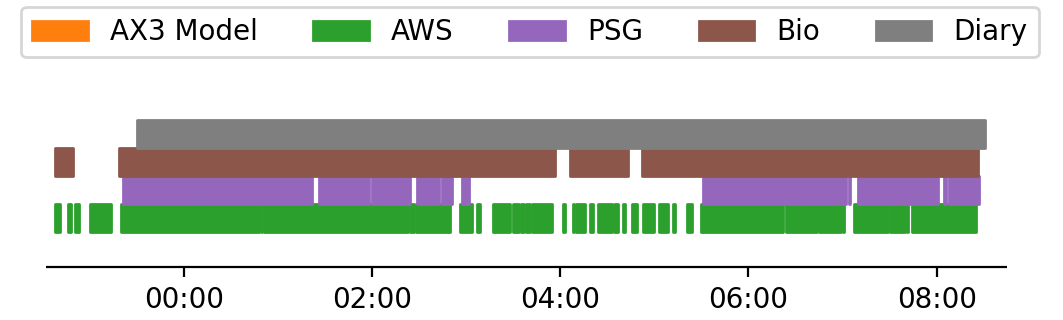

We can also look at the percentage of epochs with different labels by subject.

In [9]:
# Mismatch between PSG and AWS
aws_psg_df['PSG-AWS Disagreement %'] = (aws_psg_df['AWS Sleep'] != aws_psg_df['PSG Sleep']).astype(int)
mismatch = aws_psg_df.groupby('subject_id')['PSG-AWS Disagreement %'].mean() * 100
mismatch = mismatch.round(2).sort_values(ascending=False)
print('Percentage of epochs where PSG and AWS disagree, by subject')
mismatch.reset_index()

Percentage of epochs where PSG and AWS disagree, by subject


,subject_id,PSG-AWS Disagreement %
0,2,32.61
1,5,30.11
2,1,29.55
3,6,28.92
4,16,27.35
5,15,27.24
6,18,26.18
7,3,25.96
8,12,24.36
9,17,18.50


The Cohen's Kappa between PSG and AWS is 0.35, which again points to considerable misalignmnet between the two.

In [10]:
from sklearn.metrics import cohen_kappa_score

kappa = round(cohen_kappa_score(y1=aws_psg_df['AWS Sleep'], y2=aws_psg_df['PSG Sleep']), 2)
print(f"Cohen's Kappa between PSG and AWS: {kappa}")


Cohen's Kappa between PSG and AWS: 0.35


# Simulation

Below is the code for the simulation described at the top.

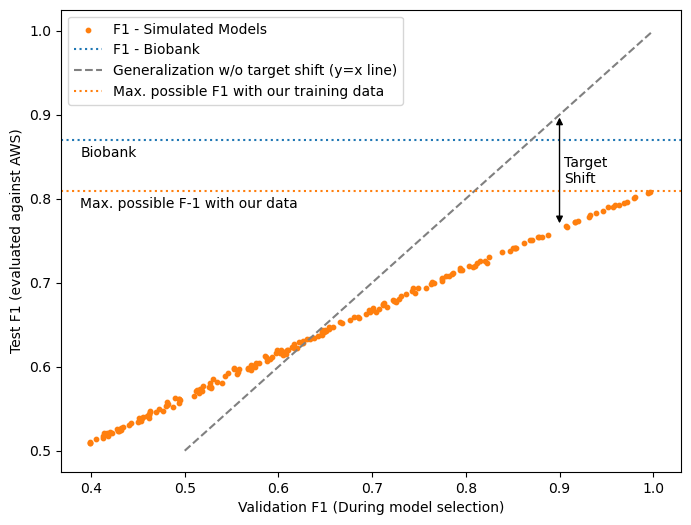

In [11]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

n_iters = 200
train_perf = []
test_perf = []
metric_average_method = 'weighted'  # weighted or macro
biobank_perf = f1_score(y_true=nan_free_temp_df['AWS Sleep'], y_pred=nan_free_temp_df['Biobank Sleep'], average=metric_average_method)
for _ in range(n_iters):
    sim_df = aws_psg_df.copy().reset_index(drop=True)
    error_count = np.random.randint(0, len(aws_psg_df))
    error_loc = np.random.randint(0, len(aws_psg_df), size=error_count)

    sim_df['Sim Model'] = sim_df['PSG Sleep']
    err_fltr = sim_df.index.isin(error_loc)
    sim_df.loc[err_fltr, 'Sim Model'] = 1 - sim_df.loc[err_fltr, 'PSG Sleep']  # Injecting errors into the simulated model's output

    train_perf.append(f1_score(y_true=sim_df['PSG Sleep'], y_pred=sim_df['Sim Model'], average=metric_average_method))
    test_perf.append(f1_score(y_true=sim_df['AWS Sleep'], y_pred=sim_df['Sim Model'], average=metric_average_method))

max_possible_perf = f1_score(y_true=sim_df['AWS Sleep'], y_pred=sim_df['PSG Sleep'], average=metric_average_method)

plt.figure(figsize=(8, 6))

plt.scatter(train_perf, test_perf, s=10, label="F1 - Simulated Models", marker='o', color="C1")

plt.axhline(biobank_perf, ls='dotted', label="F1 - Biobank")
plt.xlabel('Validation F1 (During model selection)')
plt.ylabel('Test F1 (evaluated against AWS)')

x_arrow = 0.9
y_upper_arrow = x_arrow
y_lower_arrow = test_perf[np.argmin(np.abs(np.array(train_perf) - x_arrow))]

# Arrow
plt.annotate(xy=(x_arrow, y_upper_arrow), xytext=(x_arrow, y_lower_arrow), text='',
             arrowprops=dict(arrowstyle= '<|-|>', lw=1, ls='-', color="black"))
y_text = (y_lower_arrow + biobank_perf) / 2
x_text = x_arrow + 0.005
plt.annotate(xy=(x_text, y_text), text='Target\nShift', color="black")

xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.plot([.5, 1], [.5, 1], ls='dashed', color='grey', label='Generalization w/o target shift (y=x line)')

plt.axhline(max_possible_perf, ls='dotted', color="C1", label='Max. possible F1 with our training data')

plt.annotate(xy=(xlims[0] + 0.02, biobank_perf - 0.02), text='Biobank')
plt.annotate(xy=(xlims[0] + 0.02, max_possible_perf - 0.02), text='Max. possible F-1 with our data')
plt.legend()
plt.show()